In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
import os
import plotly.graph_objects as go
import plotly.express as px
from sklearn.svm import SVR

In [2]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [3]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [4]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [5]:
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 1
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
data = load_single_timeseries(subject=0, experiment=my_exp,run=my_run,remove_mean=True)

idx = np.array([303])

data = data[idx]
data.shape

(1, 253)

In [6]:
def DataForTimeSeries():
    idx = np.array([303])
    NumberofSubjects = 339
    subjects = range(NumberofSubjects)
    conditionWin = 'win'
    my_exp  = 'GAMBLING'
    Xs = []
    for i in subjects:
        data = load_single_timeseries(subject=i, experiment=my_exp,run=my_run,remove_mean=True)
        data = data[idx]
        Xs.append(data)
    
    return Xs


X = DataForTimeSeries()

      
    

In [7]:
X = np.array(X)
X = X.reshape(339,253)
X.shape

(339, 253)

In [8]:
def makeTimeSeries(X , lag):
    z =  X
    Xs = np.array([])
    ys = np.array([])
    for i in range(len(z)):
        Xs1=np.array([])
        ys1 = np.array([])
        for k in range(len(z[i]) - lag):
         
            Xs1 = np.append(z[i][k:k+lag] , Xs1)
            ys1 = np.append(z[i][k+lag:k+lag+1],ys1)
            

      
    
        Xs = np.append(Xs , Xs1)
        ys = np.append(ys , ys1)
        
        Xs = Xs.reshape(len(ys) , -1)
        ys = ys.reshape(len(ys) , 1)
    
    return Xs , ys

Xs , ys = makeTimeSeries(X , lag = 24)


print(f'Xs shape {Xs.shape}\nYs shape {ys.shape}') 

Xs shape (77631, 24)
Ys shape (77631, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.25, random_state=0)
print(f'X_train shape is {X_train.shape}\nX_test shape is {X_test.shape} \ny_train shape is {y_train.shape} \ny_test shape is {y_test.shape}')

X_train shape is (58223, 24)
X_test shape is (19408, 24) 
y_train shape is (58223, 1) 
y_test shape is (19408, 1)


In [10]:
def get_models(models=dict()):
    models['DecisionTreeRegressor'] = DecisionTreeRegressor()
    models['LinearRegression'] = LinearRegression()
    models['GradientBoosting'] = GradientBoostingRegressor(n_estimators=100)

    return models

In [11]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

feature_transformer = scaler_X.fit(X_train)
target_trasformer = scaler_y.fit(y_train)


X_train = feature_transformer.transform(X_train)
X_test = feature_transformer.transform(X_test)
y_train = target_trasformer.transform(y_train)
y_test = target_trasformer.transform(y_test)


In [12]:
def evaluate_models(models, Xtrain, yTrain, Xtest , yTest):
    mae = dict()
    for name, model in models.items():
        regressor = model
        regressor.fit(Xtrain, yTrain)  models['SVR'] = SVR(kernel = 'poly')
        y_pred = regressor.predict(Xtest)
        y_pred = target_trasformer.inverse_transform(y_pred)
        y_real = target_trasformer.inverse_transform(yTest)

        plt.plot(y_real[50:100],marker='.', label="true")
        plt.plot(y_pred[50:100],'r', label="prediction")
        plt.title(name)
        plt.legend()
        plt.show()
        maeModel = mean_absolute_error(y_real,y_pred)
        mae[f'{name}'] = (maeModel)
    return mae

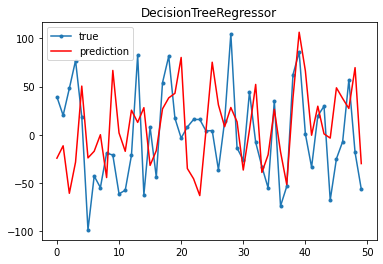

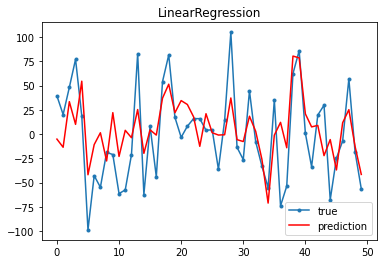

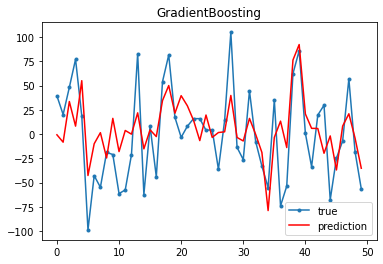

{'DecisionTreeRegressor': 44.0772565386019,
 'LinearRegression': 30.873350419433496,
 'GradientBoosting': 30.859372874866846}

In [13]:
models = get_models()
evaluate_models(models, X_train, np.ravel(y_train),X_test,np.ravel(y_test))